#### Aims:
Test whether an integrated SHO kernel (which is physically motivated & should correctly represent the true behavior of the RVs) outperforms a non-integrated SHO kernel. This is done using the simplest data possible: single-mode oscillations generated using the same `celerite` GP as is being used to fit.*

**caveat: the amplitude might be off due to differences in how celerite integrates & how I integrate.*

#### Differences between this notebook & `hello-integrated-world`:
- longer time baseline, to enable...
- more options for sampling: randomized vs. N observations every N nights
- randomized sampling is fully randomized (can be within physical limits), rather than on a interval with slight perturbations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano
import theano.tensor as tt
from exoplanet.gp import terms, GP

In [2]:
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing" # thx dfm

In [3]:
xo.__version__

'0.2.6'

In [4]:
np.random.seed(42)

In [5]:
#knobs:
exp_time = 4. * 60. # seconds
n_exp = 32
noise_amp = 0.1 # m/s white noise
N_per_N = 4 # if >= 0, take N consecutive exposures with pauses in between

#### generate RVs on a dense grid of times:

In [6]:
log_S0 = -1.0
log_Q = 7.0
log_omega0 = np.log(2.*np.pi / 300.) # 5-minute period

In [7]:
kernel_onemode = celery.terms.SHOTerm(log_S0, log_Q, log_omega0)

In [8]:
dt = 10. # grid spacing (s)
duration = 3. * 3600. # s
t_all = np.arange(0, duration, dt)

In [9]:
tlim_plot = np.array([100, 10500])

In [10]:
gp_mean = 0.0 # actual center-of-mass rvs

In [11]:
gp = celery.GP(kernel_onemode, mean=gp_mean)
gp.compute(t_all)
y_all = gp.sample()

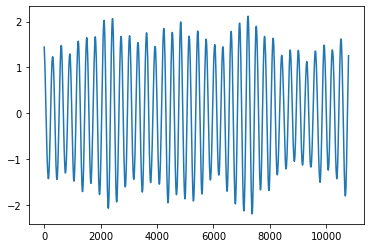

In [12]:
plt.plot(t_all, y_all);

#### bin down to simulate longer exposures:

In [13]:
from scipy.interpolate import interp1d

In [14]:
t_obs = []
y_obs = []

if N_per_N == 0:
    '''
    start_times = np.array([])
    for n in range(n_exp):
        stt = np.random.random() * (t_all[-1] - exp_time)
        is_unphysical = np.any(np.abs(stt - start_times) < exp_time) # exp starts during another exp
        while is_unphysical:
            stt = np.random.random() * (t_all[-1] - exp_time)
            is_unphysical = np.any(np.abs(stt - start_times) < exp_time) # exp starts during another exp
        start_times = np.append(start_times, stt)
    start_times = np.sort(start_times)
    '''
    start_times = np.random.random(n_exp) * (t_all[-1] - exp_time)
    start_times = np.sort(start_times)
else:
    epoch_diff = int(t_all[-1]/N_per_N) # time between epochs
    start_times = []
    for n in range(N_per_N):
        for nn in range(N_per_N):
            start_times.append(t_all[0]+n*epoch_diff+nn*exp_time)
            

interp = interp1d(t_all, y_all, kind='cubic')
tiny = 0.1 # 100 ms
for stt in start_times:
    #stt += np.abs(np.random.normal(0., 60.)) # small perturbation
    if stt+exp_time < t_all[-1]: # make sure we didn't perturb our way past the end of the data
        fine_ts = np.arange(stt, stt+exp_time, tiny) # fine grid
        fine_rvs = interp(fine_ts)
        avg_rv = np.sum(fine_rvs)/len(fine_rvs) # technically incorrect but close enough
        y_obs.append(avg_rv)
        t_obs.append(stt + exp_time/2.)

t_obs = np.array(t_obs)
y_obs = np.array(y_obs)

In [15]:
t_dense = []
y_dense = []

interp = interp1d(t_all, y_all, kind='cubic')
tiny = 0.1 # 100 ms
for stt in np.linspace(t_all[0], t_all[-1]-exp_time, 1200):
    if stt+exp_time < t_all[-1]: # make sure we didn't perturb our way past the end of the data
        fine_ts = np.arange(stt, stt+exp_time, tiny) # fine grid
        fine_rvs = interp(fine_ts)
        avg_rv = np.sum(fine_rvs)/len(fine_rvs) # technically incorrect but close enough
        t_dense.append(stt + exp_time/2.)
        y_dense.append(avg_rv)

t_dense = np.array(t_dense)
y_dense = np.array(y_dense)

In [16]:
# add photon noise:
yerr_obs = np.zeros_like(y_obs) + noise_amp
y_obs += np.random.normal(0., noise_amp, len(y_obs))

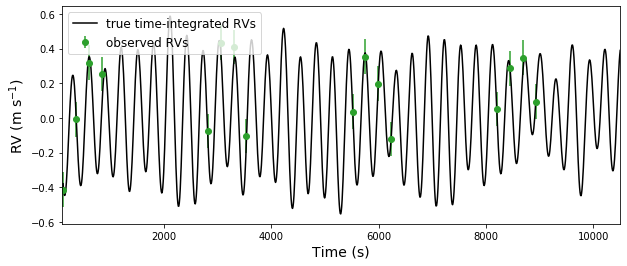

In [17]:
fig,ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(t_dense, y_dense, c='k', label='true time-integrated RVs')
ax.errorbar(t_obs, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')
ax.legend(loc='upper left', fontsize=12)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax.set_xlim(tlim_plot);

#### model with a non-integrated kernel:

This shouldn't work too well.

In [18]:
with pm.Model() as model:
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    gp = GP(kernel, t_obs, yerr_obs ** 2)
    gp.condition(y_obs)
    mu, var = xo.eval_in_model(gp.predict(t_dense, return_var=True))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict())

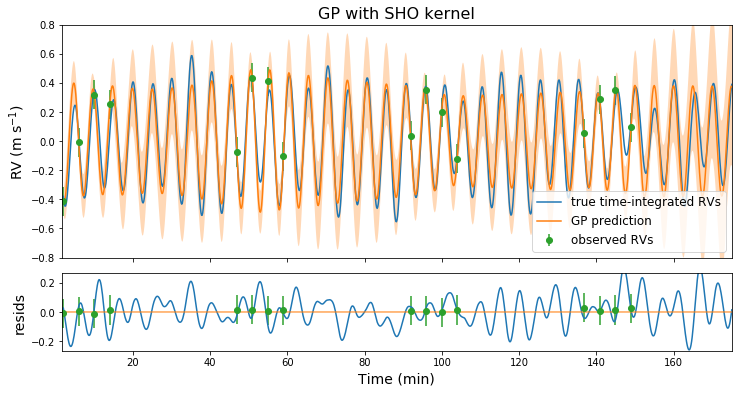

In [19]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

t_fac = 1./60. # convert seconds to minutes

#ax1.plot(t_all*t_fac, y_all, c='k', label='true RVs')
ax1.plot(t_dense*t_fac, y_dense, c='C0', label='true time-integrated RVs')
ax1.errorbar(t_obs*t_fac, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')

art = ax1.fill_between(t_dense*t_fac, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_dense*t_fac, mu, color="C1", label='GP prediction')
ax1.legend(fontsize=12)
ax2.errorbar(t_obs*t_fac, y_obs - y_pred, yerr_obs, c='C2', ls='', marker='o')
ax2.plot(t_dense*t_fac, y_dense - mu, color='C0')
ax2.plot(t_dense*t_fac, np.zeros_like(mu), color="C1", alpha=0.7)
ax2.set_xlabel('Time (min)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel(r'resids', fontsize=14)
ax1.set_xlim(tlim_plot*t_fac)
ax1.set_title('GP with SHO kernel', fontsize=16);

ax1.set_ylim([-0.8, 0.8])

#hack to get same m/s/inch in each panel:
ax1_lim = ax1.get_ylim()
scaled_lim = np.array(ax1_lim) * 1./3.
ax2.set_ylim(scaled_lim);

#plt.savefig('gp_nonintegrated.png');

In [20]:
print(np.sum((y_dense - mu)**2/var))

289.4780973350847


#### model with an integrated kernel:

This *should* work well.

In [21]:
with pm.Model() as model:
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    kernel_int = terms.IntegratedTerm(kernel, exp_time)
    gp = GP(kernel_int, t_obs, yerr_obs ** 2)
    gp.condition(y_obs)
    mu, var = xo.eval_in_model(gp.predict(t_dense, return_var=True, kernel=kernel_int))
    mu_nonint = xo.eval_in_model(gp.predict(t_dense, kernel=kernel))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict()) # predictions for training data

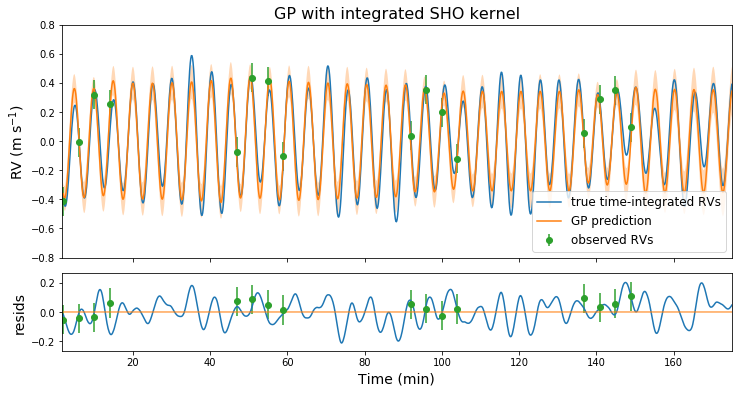

In [22]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,6), sharex=True, 
                              gridspec_kw={'height_ratios':[3,1], 'hspace':0.1})

t_fac = 1./60. # convert seconds to minutes

ax1.plot(t_dense*t_fac, y_dense, c='C0', label='true time-integrated RVs')
ax1.errorbar(t_obs*t_fac, y_obs, yerr_obs, c='C2', label='observed RVs', ls='', marker='o')

art = ax1.fill_between(t_dense*t_fac, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
ax1.plot(t_dense*t_fac, mu, color="C1", label='GP prediction')
#ax1.plot(t_dense*t_fac, mu_nonint, color="C3", label='non-integrated GP')
ax1.legend(fontsize=12)
ax2.errorbar(t_obs*t_fac, y_obs - y_pred, yerr_obs, c='C2', ls='', marker='o')
ax2.plot(t_dense*t_fac, y_dense - mu, color='C0')
ax2.plot(t_dense*t_fac, np.zeros_like(mu), color="C1", alpha=0.7)

ax2.set_xlabel('Time (min)', fontsize=14)
ax1.set_ylabel(r'RV (m s$^{-1}$)', fontsize=14)
ax2.set_ylabel(r'resids', fontsize=14)
ax1.set_xlim(tlim_plot*t_fac)
ax1.set_title('GP with integrated SHO kernel', fontsize=16);

ax1.set_ylim([-0.8, 0.8])

#hack to get same m/s/inch in each panel:
ax1_lim = ax1.get_ylim()
scaled_lim = np.array(ax1_lim) * 1./3.
ax2.set_ylim(scaled_lim);

#plt.savefig('gp_integrated.png');

In [23]:
print(np.sum((y_dense - mu)**2/var))

698.4678378960296
